In [1]:
import cv2
import torch
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
import xml.etree.ElementTree as ET
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
from pathlib import Path
from tqdm import tqdm, tqdm_notebook
from torchvision import transforms


In [2]:
import xml.etree.ElementTree as ET


# разные режимы датасета
DATA_MODES = ['train', 'val', 'test']

# работаем на видеокарте
DEVICE = torch.device("cuda")


torch.cuda.is_available()
# 55 orange
# 53 apple
# 52 banana
Labels = {
    'orange': 1,
    'banana': 2,
    'apple': 3,

}

widthR, heightR =(600, 400)

class CustomDataset(Dataset):
    """
    Датасет с картинками, который паралельно подгружает их из папок
    производит скалирование и превращение в торчевые тензоры
    """

    def __init__(self, files, mode):
        super().__init__()
        # список файлов для загрузки
        self.files = sorted(files)
        # режим работы
        self.mode = mode

        if self.mode not in DATA_MODES:
            print(f"{self.mode} is not correct; correct modes: {DATA_MODES}")
            raise NameError

        self.len_ = len(self.files)

    def __len__(self):
        return self.len_

    def load_sample(self, file):
        img_numpy = cv2.imread(str(file))[:, :, ::-1]
        height, width = img_numpy.shape[:2]
        k1=width/widthR 
        k2=height/heightR
        
        img = cv2.resize(img_numpy, (widthR, heightR))
        img = torch.from_numpy(img.astype('float32')).permute(2, 0, 1)
        img = img / 255.
        # print(img[None, ...].shape)
        return img, (k1,k2)

    # def getTargetandLabelTensor(self, target):
    #     npTarget = np.empty(0)
    #     npLabels = np.empty(0)
    #     for t in target:
    #         npLabels = np.append(npLabels, Labels[t['name']])
    #         npTarget = np.append(npTarget, np.array([t['xmin'], t['ymin'], t['xmax'], t['ymax']]))
    #     return torch.from_numpy(npTarget.astype('float32'))[None, ...], torch.from_numpy(npLabels.astype('int64'))[
    #         None, ...]

    def getTarget(self, xml, kt):
        tree = ET.parse(xml)
        tree.findall('object')
        boxes = []
        labels = []
        for obj in tree.findall('object'):
            name = obj.find('name').text
            box = obj.find('bndbox')
            xmin = np.float(box.find('xmin').text)/kt[0]
            ymin = np.float(box.find('ymin').text)/kt[1]
            xmax = np.float(box.find('xmax').text)/kt[0]
            ymax = np.float(box.find('ymax').text)/kt[1]
            boxes.append([xmin,ymin,xmax,ymax])
            labels.append(Labels[name])
        d = {}
        d ["boxes"] = torch.as_tensor(boxes, dtype=torch.float32)
        d ["labels"] = torch.as_tensor(labels, dtype=torch.int64) 
        return d

    def __getitem__(self, index):
        # print(self.files[index])
        img,kt = self.load_sample(self.files[index])
        targets = self.getTarget(str(self.files[index]).replace('jpg', 'xml'), kt) 
        # print(targets["boxes"])       
        if self.mode == 'train':
            return img, targets
        elif self.mode == 'val':

            return img, targets
        else:
            return img

In [3]:
def set_parameter_requires_grad(model):
  for param in model.parameters():
      param.requires_grad = True
class CustomFasterRCCN(nn.Module):
  
    def __init__(self, n_classes):
        super().__init__()

        self.model_ft = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True).cuda()
        # get the number of input features for the classifier
        in_features = model.roi_heads.box_predictor.cls_score.in_features 
        # replace the pre-trained head with a new one
        self.model_ft.roi_heads.box_predictor = FastRCNNPredictor(in_features, n_classes).cuda()
        set_parameter_requires_grad(self.model_ft.roi_heads.box_predictor)

    def forward(self, img, target):        

        logits = self.model_ft(img, target)
        return logits
def get_object_detection_model(num_classes):
    # load an object detection model pre-trained on COCO
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True).cuda()
    
    # get the number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
 
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes).cuda()
 
    return model

In [4]:
def iou(boxA, boxB):
    # determine the (x, y)-coordinates of the intersection rectangle
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])

    # compute the area of intersection rectangle
    interArea = abs(max((xB - xA, 0)) * max((yB - yA), 0))
    if interArea == 0:
        return 0
    # compute the area of both the prediction and ground-truth
    # rectangles
    boxAArea = abs((boxA[2] - boxA[0]) * (boxA[3] - boxA[1]))
    boxBArea = abs((boxB[2] - boxB[0]) * (boxB[3] - boxB[1]))

    # compute the intersection over union by taking the intersection
    # area and dividing it by the sum of prediction + ground-truth
    # areas - the interesection area
    iou = interArea / float(boxAArea + boxBArea - interArea)

    # return the intersection over union value
    return iou

def fit_epoch(model, train_loader, optimizer):
    running_loss = 0.0
    running_corrects = 0
    processed_data = 0
    i=0
    for img, targets in train_loader:
        i += 1
        # print(img[0].shape)
        img = list(img.to(DEVICE) for img in img)
        targets = [{k: v.to(DEVICE) for k, v in t.items()} for t in targets]
        optimizer.zero_grad()

        loss_dict = model(img,targets)
        # print(len(loss_dict))
        losses = sum(loss for loss in loss_dict.values())
        loss = losses.item()/len(loss_dict)  
        optimizer.zero_grad()
        losses.backward()
        optimizer.step()
        print(f'Iteration: {i}/{len(train_loader)}, Loss: {loss}')
        running_loss += loss           
    train_loss = running_loss / i
    return train_loss

def eval_epoch(model, val_loader):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    processed_size = 0
    i=0
    for img, targets in val_loader:
        i += 1
        img = list(img.to(DEVICE) for img in img)
        targets = [{k: v.to(DEVICE) for k, v in t.items()} for t in targets]

        with torch.set_grad_enabled(False):
            loss_dict = model(img)
            print(loss_dict)
        # running_corrects += torch.sum(preds == labels.data)
        # processed_size += 1
    # val_loss = running_loss / processed_size
    val_acc = running_corrects.double() / processed_size
    return  val_acc

# collate_fn needs for batch
def collate_fn(batch):
    return tuple(zip(*batch))

def train(train_files, val_files, model, epochs, batch_size, l_r):

    train_loader = torch.utils.data.DataLoader(train_files, batch_size=batch_size,
                                          shuffle=True, num_workers=2, collate_fn=collate_fn)
    val_loader = torch.utils.data.DataLoader(train_files, batch_size=batch_size,
                                          shuffle=False, num_workers=2, collate_fn=collate_fn)

    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
    val_loss {v_loss:0.4f} train_acc {t_acc:0.4f} val_acc {v_acc:0.4f}"

    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        opt = torch.optim.AdamW(model.parameters(), lr = l_r)
        # criterion = nn.CrossEntropyLoss()
        # для уменьшения lr каждую эпоху в два раза
        scheduler = torch.optim.lr_scheduler.StepLR(opt, 1, gamma=0.5)

        for epoch in range(epochs):
            train_loss = fit_epoch(model, train_loader, opt)
            print("loss", train_loss)            
            val_acc = eval_epoch(model, val_loader)
            history.append((train_loss,  val_acc))
            
            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss,\
                                           v_loss=val_loss, v_acc=val_acc))
            scheduler.step()
            # для сохранения чекпоинтов на всякий случай
            torch.save(model.state_dict(), "gdrive/My Drive/rrcnn_" + str(epoch) + ".pth")
             
    return history

In [5]:
TRAIN_DIR = Path('/content/drive/My Drive/fruits/train_zip')
TEST_DIR = Path('/content/drive/My Drive/fruits/test_zip')
train_val_files = sorted(list(TRAIN_DIR.rglob('*.jpg')))
test_files = sorted(list(TEST_DIR.rglob('*.jpg')))



from sklearn.model_selection import train_test_split

train_files, val_files = train_test_split(train_val_files, test_size=0.25)

val_dataset = CustomDataset(val_files, mode='val')
    
train_dataset = CustomDataset(train_files, mode='train')

net= torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=False, progress=True, num_classes=4, pretrained_backbone=True).to(DEVICE)

history = train(train_dataset, val_dataset, model=net, epochs=10, batch_size=4, l_r = 0.0001)

loss, acc, val_loss, val_acc = zip(*history)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/checkpoints/resnet50-19c8e357.pth


epoch:   0%|          | 0/10 [00:00<?, ?it/s]/pytorch/torch/csrc/utils/python_arg_parser.cpp:756: UserWarning: This overload of nonzero is deprecated:
	nonzero(Tensor input, *, Tensor out)
Consider using one of the following signatures instead:
	nonzero(Tensor input, *, bool as_tuple)


Streaming output truncated to the last 5000 lines.
        [175.0858,  86.3460, 368.5354, 263.7735],
        [ 27.2793, 298.9973, 195.9478, 400.0000],
        [202.8210, 298.4957, 372.0327, 400.0000],
        [250.7849, 166.2314, 450.2730, 345.1907],
        [ 45.3627, 100.6405, 243.7815, 280.2120],
        [282.4761, 299.3324, 450.5980, 400.0000],
        [447.9388, 262.7389, 600.0000, 400.0000],
        [430.6194, 149.9178, 600.0000, 328.2046],
        [487.3142, 121.0245, 600.0000, 293.1535],
        [464.2281,   0.0000, 600.0000, 131.7696],
        [387.0091, 195.0006, 591.4046, 400.0000],
        [  0.0000, 131.0507, 182.8625, 313.8322],
        [  0.0000, 102.6832, 108.6385, 282.0032],
        [284.4410, 100.6342, 483.5020, 280.2469]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 3, 2, 3, 2, 2, 3, 2,
        2, 2, 3, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 3, 3, 3, 2, 2, 3, 3, 2, 3,
        3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3

epoch:   0%|          | 0/10 [03:27<?, ?it/s]

[{'boxes': tensor([[2.4662e+02, 1.8984e+01, 4.6271e+02, 4.0000e+02],
        [8.2858e+01, 1.4160e+02, 4.4972e+02, 4.0000e+02],
        [1.3148e+02, 1.2143e+02, 3.2231e+02, 4.0000e+02],
        [9.9598e+01, 2.5536e+02, 5.2024e+02, 4.0000e+02],
        [3.0178e+02, 8.0846e+01, 6.0000e+02, 3.9558e+02],
        [6.4012e+01, 3.3378e+01, 2.5938e+02, 4.0000e+02],
        [5.2942e+01, 2.9431e+01, 4.1629e+02, 3.3883e+02],
        [2.4236e+02, 3.5254e+01, 6.0000e+02, 2.5666e+02],
        [8.2672e-02, 6.1253e+01, 3.0799e+02, 2.8343e+02],
        [4.5287e+02, 2.4447e+01, 6.0000e+02, 4.0000e+02],
        [0.0000e+00, 6.2460e+01, 1.5736e+02, 4.0000e+02],
        [8.0510e+01, 8.9286e+01, 5.2976e+02, 3.0898e+02],
        [1.0568e+02, 3.5687e+01, 4.8043e+02, 3.2633e+02],
        [1.4579e+02, 1.4986e+02, 5.8926e+02, 3.6779e+02],
        [2.1926e+02, 8.9717e+01, 4.2551e+02, 4.0000e+02],
        [2.8495e+02, 5.8049e+01, 4.8878e+02, 4.0000e+02],
        [1.7785e+01, 5.1326e+01, 3.9219e+02, 3.6184e+02],
   

AttributeError: ignored

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "


[{'boxes': tensor([[338.3730, 235.6573, 455.2375, 332.6047],
        [296.4012,   3.5347, 427.2771, 134.4338],
        [424.2361, 118.9140, 559.0212, 248.4314],
        [ 84.4041, 121.1583, 227.4385, 266.6799],
        [159.9774, 202.7944, 298.7270, 326.9990],
        [ 86.9423,  51.9254, 190.9009, 146.7791],
        [245.0485, 125.6166, 383.0879, 266.2245],
        [179.1224,  24.5000, 307.8143, 163.2744],
        [449.6651,  55.3595, 575.4293, 164.3844],
        [367.7036,  81.7653, 455.8686, 204.3887],
        [ 78.1081,   1.3457, 456.3848, 274.8376],
        [214.8127,   0.0000, 575.9573, 257.7784],
        [419.0031,  54.4710, 579.1592, 228.7448],
        [293.8257,  16.3912, 457.3219, 195.2654],
        [ 77.2046,  69.9519, 284.6377, 276.2987],
        [ 91.6379,  32.2034, 266.8996, 160.6287],
        [603.7576, 186.1750, 639.4999, 215.6467],
        [ 93.1654,  13.0872, 369.4922, 188.7574],
        [ 95.3447, 137.4188, 306.9361, 322.5564],
        [226.0795,   8.5654, 384.8813, 

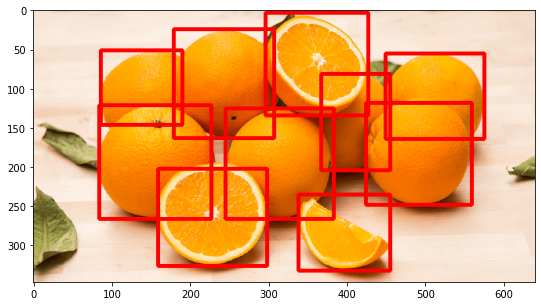

In [ ]:
def plot_preds(numpy_img, preds):
  boxes = preds['boxes'].cpu().detach().numpy()
  for box in boxes:
    numpy_img = cv2.rectangle(
        numpy_img, 
        (box[0],box[1]),
        (box[2],box[3]), 
        255,
        3
    )
  return numpy_img.get()

model = model.eval().cuda()
img_numpy = cv2.imread('/content/drive/My Drive/fruits/train_zip/train/orange_1.jpg')[:,:,::-1]
img = torch.from_numpy(img_numpy.astype('float32')).permute(2,0,1)
img = img / 255.
# print(img.shape)

predictions = model(img[None,...].cuda())
print(predictions)
# 55 orange
# 53 apple
# 52 banana
CONF_THRESH = 0.8
boxes = predictions[0]['boxes'][(predictions[0]['scores'] > CONF_THRESH) & (predictions[0]['labels'] == 55) ]
boxes_dict = {}
boxes_dict['boxes'] = boxes

img_with_boxes = plot_preds(img_numpy, boxes_dict)
print(img_with_boxes.shape)
fig = plt.figure(figsize=(10,5))
plt.imshow(img_with_boxes.astype('uint'));